# Single Cell RNAseq data of the TME of LUAD patients treated with TKI

Import packages

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np

Plotting settings

In [2]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=60, facecolor='white', color_map = 'viridis_r')
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

/home/marcc/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 pynndescent==0.5.8


## 1. Import scRNA data and meta annotations

In [3]:
adata = sc.read_h5ad('/opt/marcc/Maynard_et_al_2020.h5ad')
cca = pd.read_csv("/home/marcc/AXLomics/msresist/data/RNAseq/Maynard/cancer_cell_annotation.csv")
IDtoCNV = dict(zip(list(cca["cell_id"]), list(list(cca["inferCNV_annotation"]))))
adata.obs.insert(3, "inferCNV_annotation", [IDtoCNV[c_id] if c_id in list(IDtoCNV.keys()) else "nonepithelial" for c_id in list(adata.obs.index)])
adata = adata[adata.obs["Driver gene"] == "EGFR"]

In [4]:
adata

View of AnnData object with n_obs × n_vars = 12191 × 25733
    obs: 'Age (years)', 'Analysis', "Author's cell type", 'inferCNV_annotation', 'Best rxn status', 'Biopsy site', 'Biopsy time status', 'Biopsy timing', 'Biopsy type', 'Ca_dx_os', 'Compartment', 'Developmental stage', 'Driver gene', 'Driver mutation', 'Early bx day', 'Early treatment status', 'Final annotation', 'Gender', 'Histology', 'Immune annotation', 'Infections', 'Line of therapy', 'Louvain clustering', 'Notes', 'Number of genes', 'Number of mRNA transcripts', 'Pathology review', 'Percentage of mitochondrial genes', 'Percentage of pfs ref values', 'Percentage of pfs reference values', 'Pfs day', 'Pfs month', 'Pfs over under', 'Plate id', 'Primary or metastaic', 'Quantification', 'Race', 'Response to treatment', 'Sample ID', 'Sample source', 'Sample type', 'Sampling site', 'Sampling technique', 'Secondary mutation', 'Sequencing platform', 'Smoking history', 'Sort plate id', 'Stage', 'Stage at dx', 'Storage technique', 'Su

In [5]:
TvsNAT = adata[(adata.obs["Compartment"] == "epithelial") & (adata.obs["inferCNV_annotation"] != "NA")]
cc = adata[(adata.obs["Compartment"] == "epithelial") & (adata.obs["inferCNV_annotation"] == "cancer cell")]
adata.obs["Driver mutation"] = adata.obs["Driver mutation"].replace("del19", "Exon 19del")

/tmp/ipykernel_3500465/3170615946.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Driver mutation"] = adata.obs["Driver mutation"].replace("del19", "Exon 19del")


In [6]:
c123 = pd.read_csv("C123.csv").dropna().iloc[:, -1].to_list()
sc.tl.score_genes(adata, c123, score_name="AXL signature")
sc.tl.score_genes(TvsNAT, c123, score_name="AXL signature")
sc.tl.score_genes(cc, c123, score_name="AXL signature")

/home/marcc/.local/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/marcc/.local/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/marcc/.local/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
/home/marcc/.local/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/marcc/.local/lib/python3.10/site-packages/sca

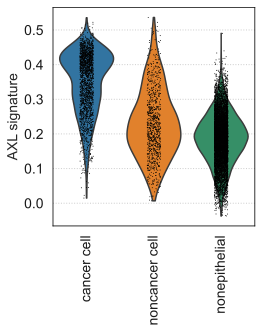

In [7]:
sc.set_figure_params(ipython_format="svg")
sc.pl.violin(adata, "AXL signature", groupby='inferCNV_annotation', rotation=90)

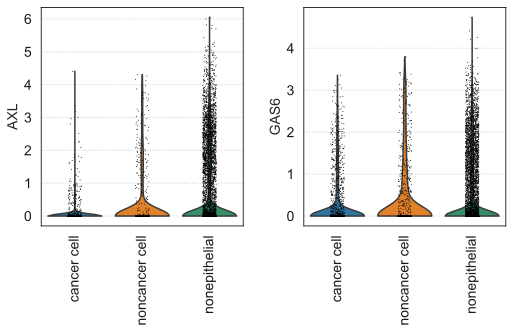

In [8]:
sc.pl.violin(adata, ["AXL", "GAS6"], groupby='inferCNV_annotation', rotation=90)

## 2. Filter and normalize data

In [9]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
# adata = adata[adata.obs.total_counts > 5000, :]

Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
sc.pp.scale(adata, max_value=10)

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [11]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

/home/marcc/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## 3. Clustering of cell populations

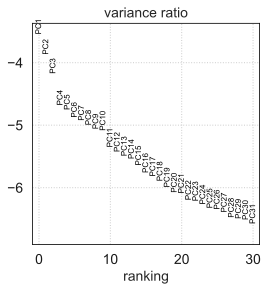

In [12]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
# plt.savefig("PCAcomps.svg")

### 3.1 Computing neighborhood graph

In [13]:
sc.tl.tsne(adata, n_pcs=20, perplexity=30)

/home/marcc/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


/home/marcc/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


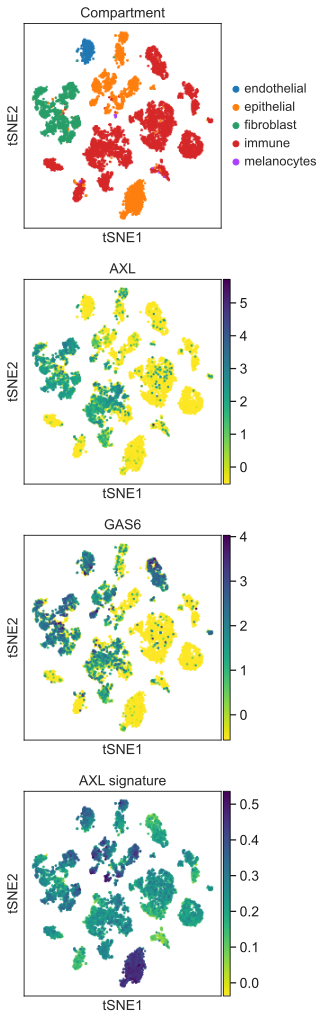

<Figure size 240x320 with 0 Axes>

In [14]:
# sc.set_figure_params(dpi=100, color_map = 'viridis_r')
sc.set_figure_params(ipython_format="svg", figsize=(3, 4), color_map='viridis_r')
sc.pl.tsne(adata, color=["Compartment", "AXL", "GAS6", "AXL signature"], frameon=True, s=20, ncols=1)
plt.tight_layout()

### 4 Tumor analysis

In [15]:
# TvsNAT = adata[(adata.obs["Compartment"] == "epithelial") & (adata.obs["inferCNV_annotation"] != "NA")]
# sc.tl.pca(TvsNAT, svd_solver='arpack')
# sc.tl.tsne(TvsNAT, n_pcs=10, perplexity=30)
# sc.pl.tsne(TvsNAT, color=["Analysis", "Primary or metastaic", "inferCNV_annotation"], ncols=1)

In [16]:
# with plt.rc_context():
#     sc.pl.violin(TvsNAT, ['AXL', 'GAS6', 'AXL signature'], groupby='inferCNV_annotation')
#     sc.pl.violin(TvsNAT, ['AXL', 'GAS6', 'AXL signature'], groupby='Analysis')
#     sc.pl.violin(TvsNAT, ['AXL', 'GAS6', 'AXL signature'], groupby='Primary or metastaic')

In [17]:
cc = adata[(adata.obs["Compartment"] == "epithelial") & (adata.obs["inferCNV_annotation"] == "cancer cell")]
cc = cc[(cc.obs["Primary or metastaic"] != "Unassigned")]
sc.tl.pca(cc, svd_solver='arpack')
sc.tl.tsne(cc, n_pcs=10, perplexity=30)

/home/marcc/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


/home/marcc/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/marcc/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


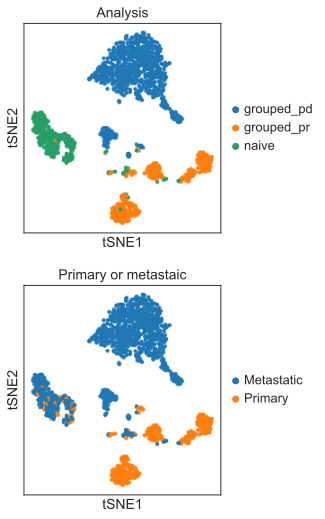

<Figure size 240x320 with 0 Axes>

In [19]:
sc.set_figure_params(ipython_format="svg", figsize=(3, 4), color_map='viridis_r')
sc.pl.tsne(cc, color=["Analysis", "Primary or metastaic"], ncols=1)
plt.savefig("tsne_pd_met.svg")

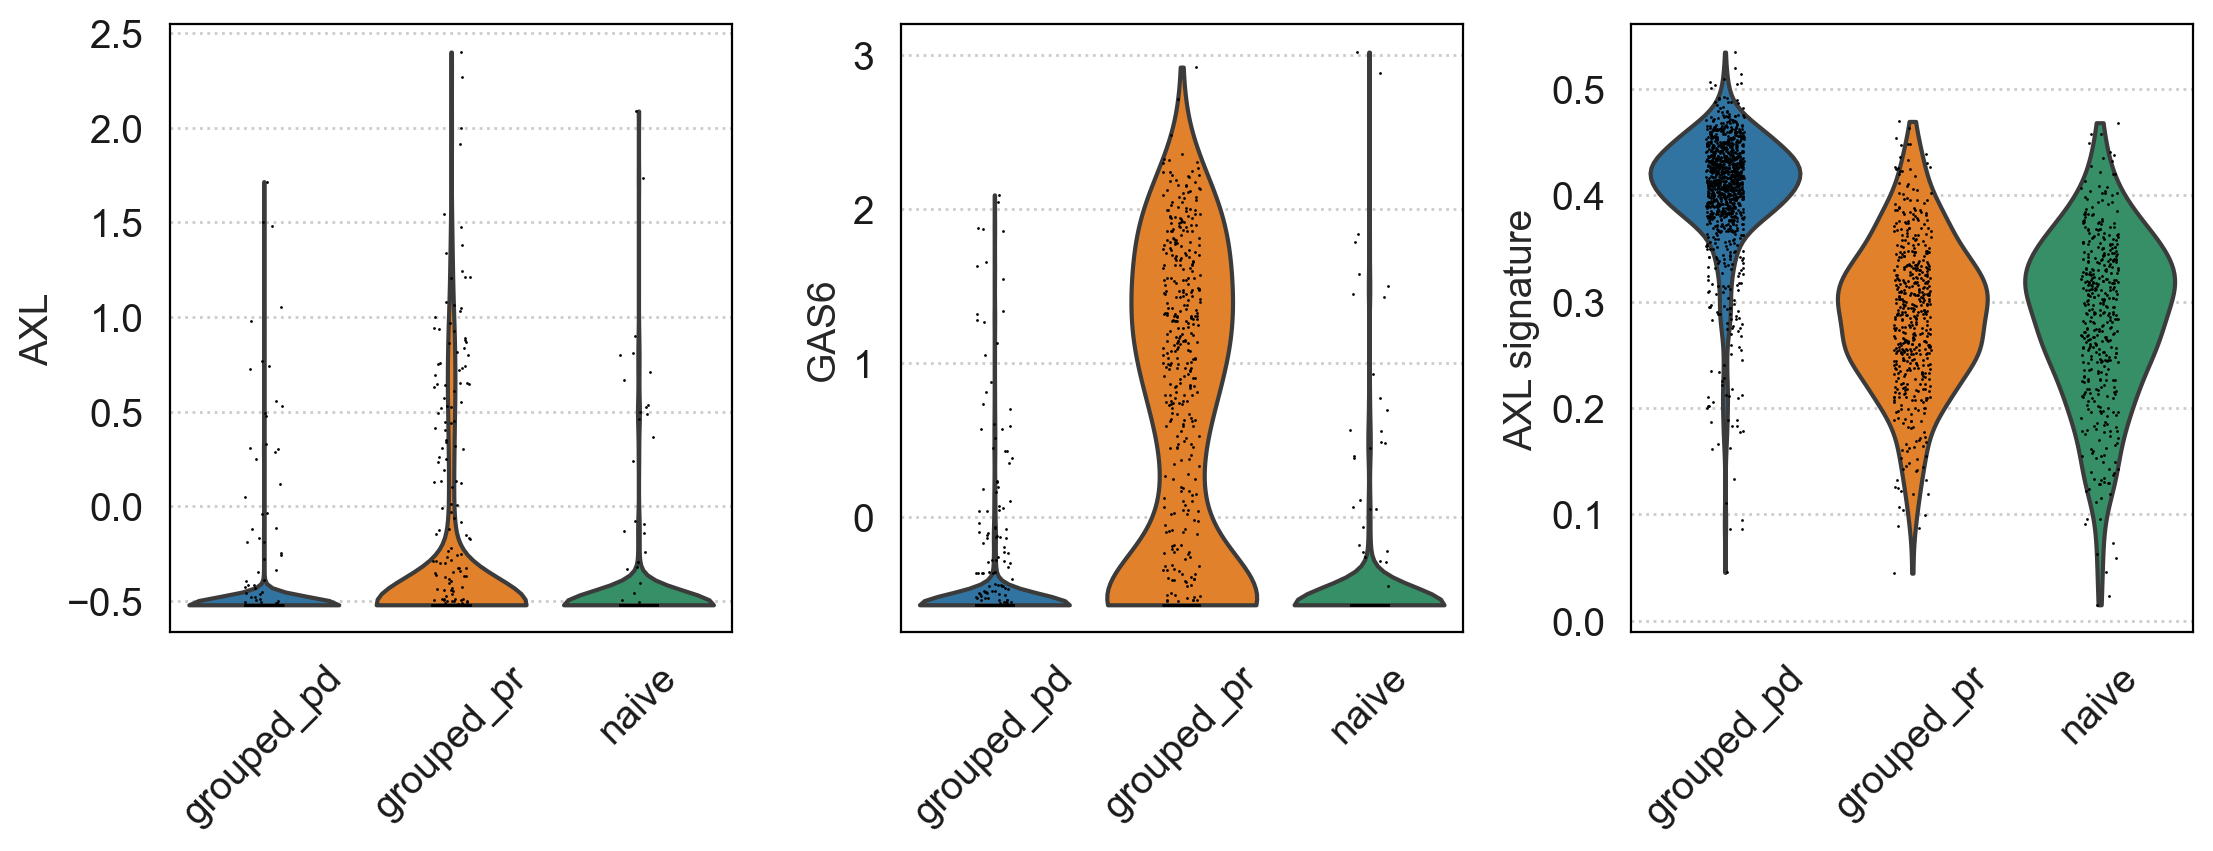

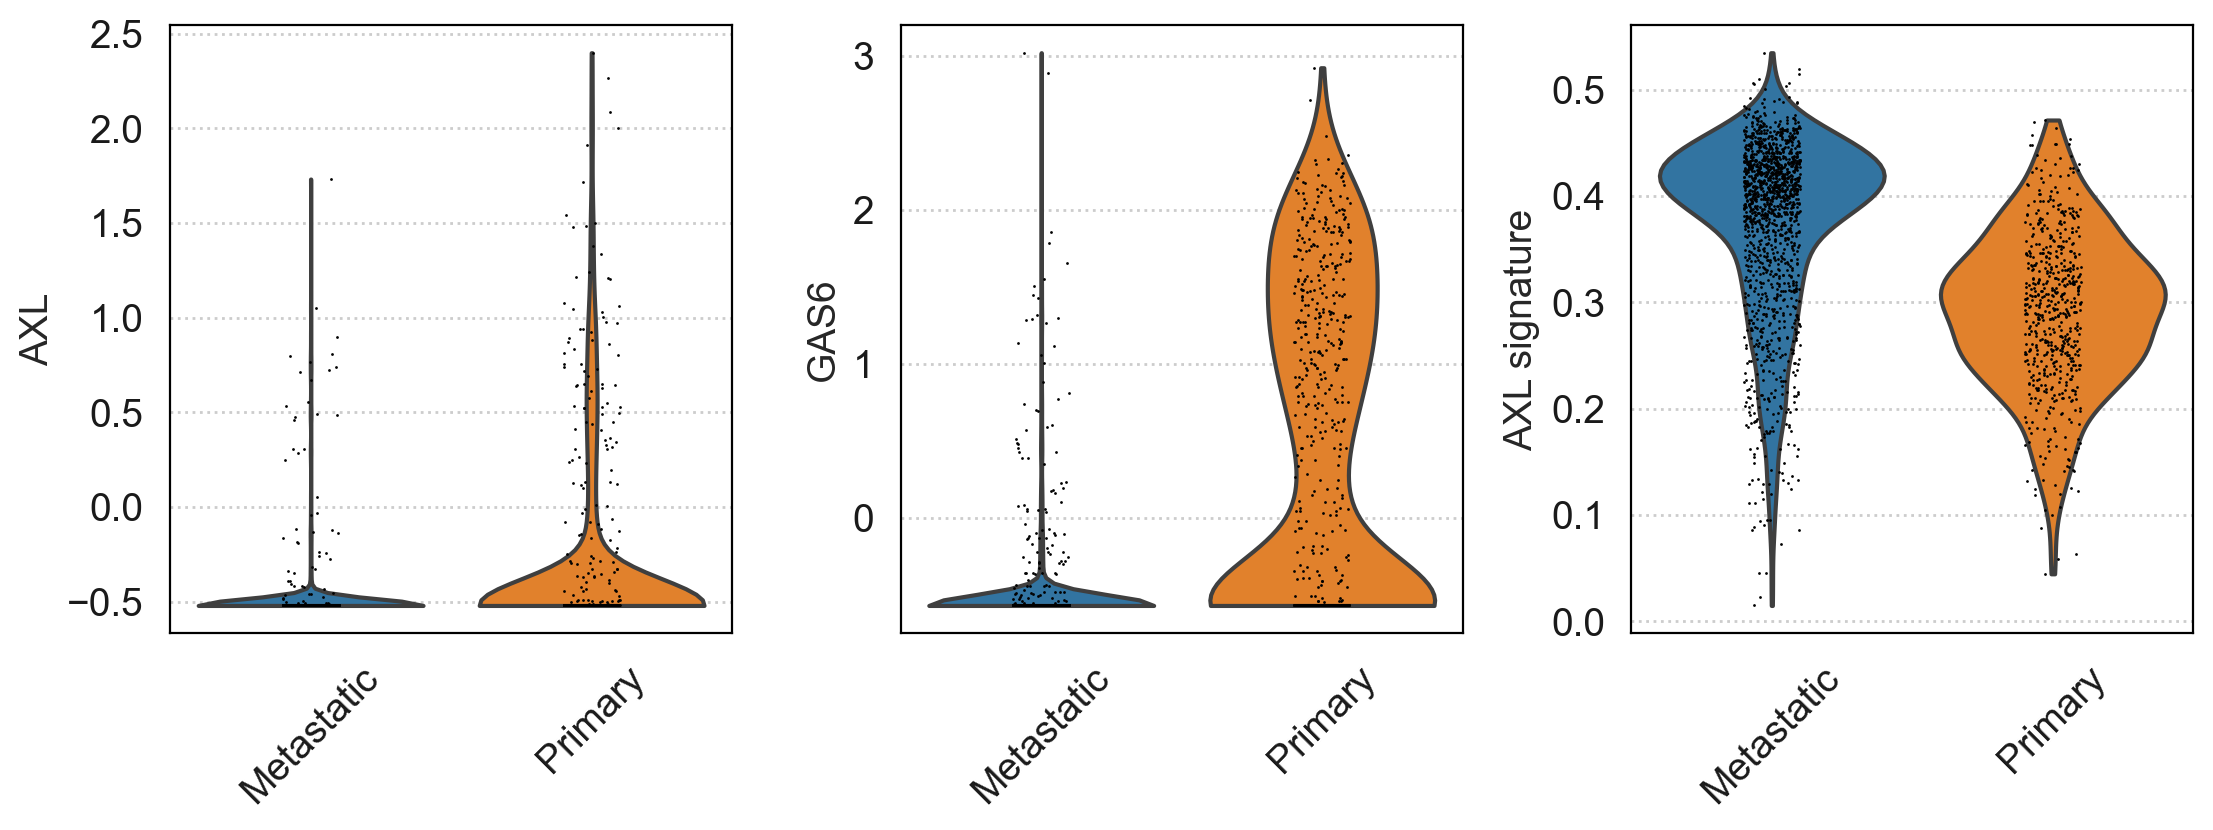

In [33]:
sc.pl.violin(cc, ["AXL", "GAS6", "AXL signature"], rotation=45, groupby='Analysis')
sc.pl.violin(cc, ["AXL", "GAS6", "AXL signature"], rotation=45, groupby='Primary or metastaic')